In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import numpy as np
import warnings
from detoxify import Detoxify

pd.set_option('display.max_colwidth', None)
tqdm.pandas()
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
reduced_data = pd.read_csv("/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/war_data/cleaned_data.csv")
reduced_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 745941 entries, 0 to 745940
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   date          745941 non-null  object
 1   cleanedTweet  745941 non-null  object
dtypes: object(2)
memory usage: 11.4+ MB


In [3]:
with open('sentiment_results_10000.json') as f:
    results = json.load(f)
print(f"{len(results)} entries in JSON file")

10000 entries in JSON file


In [4]:
candidate_labels = ['USA started the war',
                        'POTUS started the war',
                        'Joe Biden started the war',
                        'CIA started the war',
                        'USA influenced the war',
                        'POTUS influenced the war',
                        'Joe Biden influenced the war',
                        'CIA influenced the war']

In [5]:
label_scores = {label: [] for label in candidate_labels}
for scores in results.values():
    for l, s in scores.items():
        label_scores[l].append(s)

In [17]:
def plot_histogram(label_scores):
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
    axs = axs.flatten()
    final_plot = len(label_scores)

    for i, (label, scores) in enumerate(label_scores.items()):
        axs[i].hist(scores, bins=50, range=(0, 1))
        axs[i].set_xlabel('Value')
        axs[i].set_ylabel('Frequency')
        axs[i].set_title(f'Histogram for "{label}"')
        axs[i].set_yscale('log')

    all_scores = [value for values in label_scores.values() for value in values]
    axs[final_plot].hist(all_scores, bins=50, range=(0, 1))
    axs[final_plot].set_xlabel('Value')
    axs[final_plot].set_ylabel('Frequency')
    axs[final_plot].set_title("Histogram for All Prompts")
    axs[final_plot].set_yscale('log')

    plt.tight_layout()
    plt.show()

    counts, bins = np.histogram(all_scores, bins=10, range=(0, 1))

    for i, count in enumerate(counts):
        lower_bound = bins[i]
        upper_bound = bins[i+1]
        print(f"{lower_bound:.2f} - {upper_bound:.2f}: {count}")


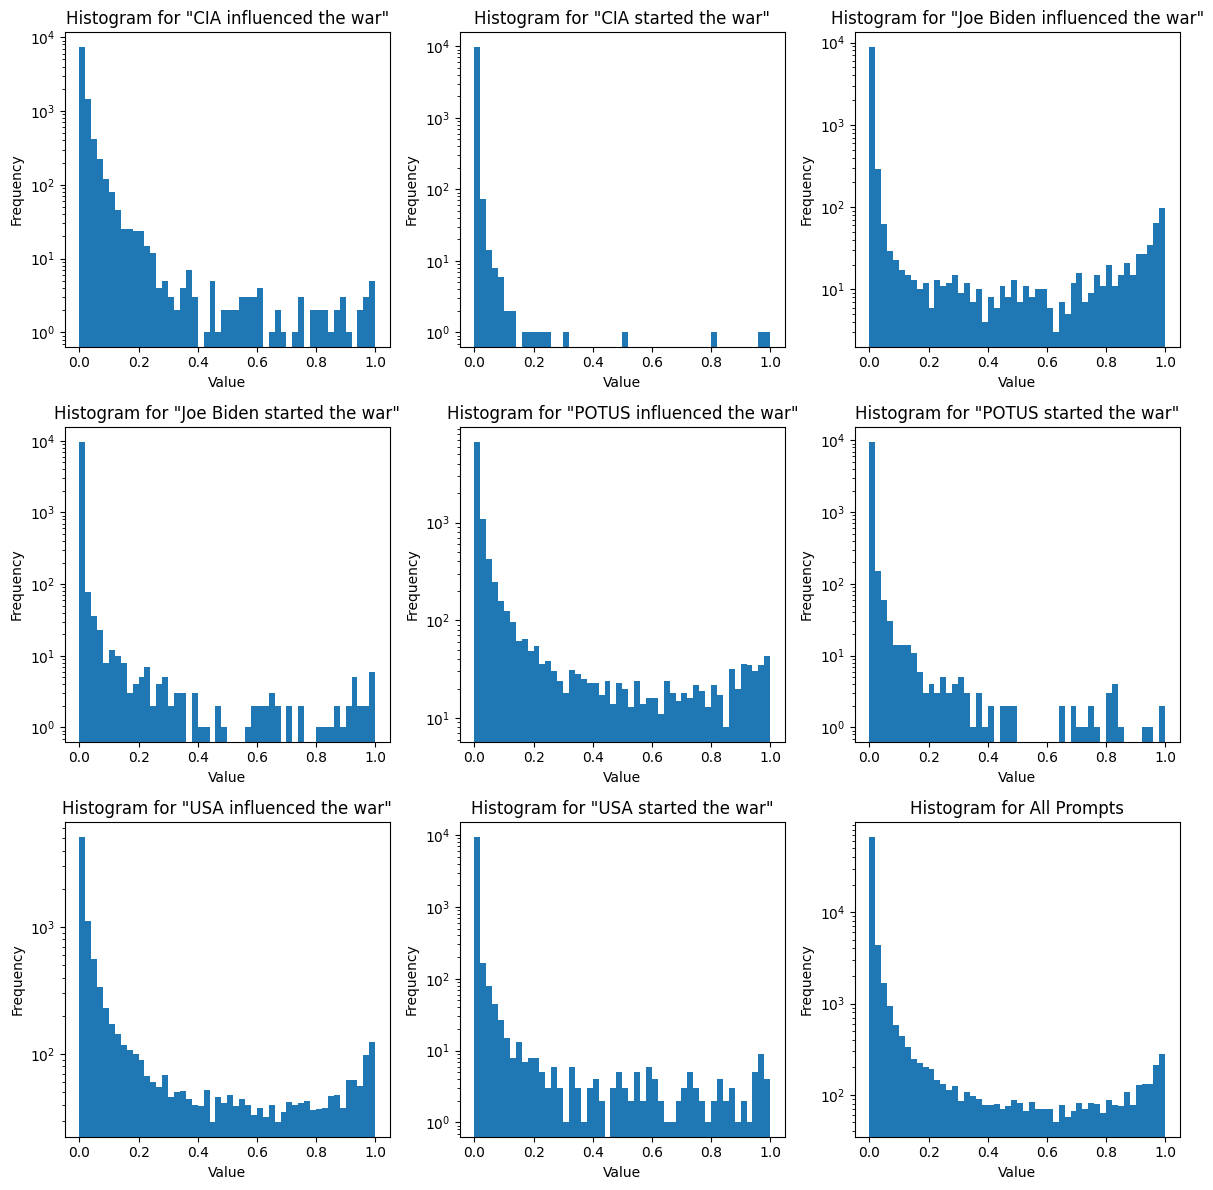

0.00 - 0.10: 74612
0.10 - 0.20: 1448
0.20 - 0.30: 709
0.30 - 0.40: 456
0.40 - 0.50: 390
0.50 - 0.60: 372
0.60 - 0.70: 322
0.70 - 0.80: 377
0.80 - 0.90: 426
0.90 - 1.00: 888


In [18]:
label_scores = dict(sorted(label_scores.items()))
plot_histogram(label_scores)

In [ ]:
toxify = Detoxify('original')
toxicity_scores = {
    'toxicity': [],
    'severe_toxicity': [],
    'obscene': [],
    'threat': [],
    'insult': [],
    'identity_attack': [],
}
for tweet in tqdm(results.keys()):
    result = toxify.predict(tweet)
    for label, score in result.items():
        toxicity_scores[label].append(score)

In [ ]:
plot_histogram(toxicity_scores)

In [19]:
tweets_per_threshold = {
    0.6: 0,
    0.7: 0,
    0.75: 0,
    0.8: 0,
    0.9: 0,
    0.95: 0,
}
for tweet, scores in results.items():
    for threshold in tweets_per_threshold.keys():
        if any(score > threshold for score in scores.values()):
            tweets_per_threshold[threshold] += 1

for threshold, count in tweets_per_threshold.items():
    print(f"{threshold}: {count} tweets ({round(count / len(results) * 100, 2)}%)")

0.6: 1472 tweets (14.72%)
0.7: 1272 tweets (12.72%)
0.75: 1150 tweets (11.5%)
0.8: 1012 tweets (10.12%)
0.9: 714 tweets (7.14%)
0.95: 467 tweets (4.67%)


In [13]:
tweet_scores = []
for tweet, scores in results.items():
    max_pair = max(scores.items(), key=lambda x: x[1])
    tweet_scores.append((tweet, max_pair[0], max_pair[1], 0.8 - max_pair[1]))

just_below = [(t, l, s, d) for (t, l, s, d) in tweet_scores if d < 0]
just_above = [(t, l, s, d) for (t, l, s, d) in tweet_scores if d >= 0]

In [23]:
import operator

print("Above")
just_above.sort(key=operator.itemgetter(3))
for (t, l, s, _) in just_above[:20]:
    print(f"{t}:\n\t{l}: {s}")

print("Below")
just_below.sort(key=operator.itemgetter(3), reverse=True)
for (t, l, s, _) in just_below[:20]:
    print(f"{t}:\n\t{l}: {s}")

Above
Useful Idiot Tulsi Gabbard Says Biden Administration Wants Russia to Invade Ukraine:
	Joe Biden influenced the war: 0.7999839782714844
they aren't making postures, the US claims they are and russia keeps denying it. the US wants an excuse to come in, for ukraine to join nato. russia said no. and russia will fight in the winter if attacked. i'm not sure what will go down, but it will be soon.:
	USA influenced the war: 0.799587607383728
BBC NewsNight, Feb Why does the US think Russia will invade Ukraine in the coming days? UkraineCrisis Russiafalseflag:
	USA influenced the war: 0.7994421124458313
The US would have done something very similar if some Russian alliance would weapons and maybe troops in, say, Cuba. Remember that??? NATO has been spreading east since the end of WWII. I am against wars but this one is not as bad as the invasion of Iraq:
	USA influenced the war: 0.7989681363105774
EU outlines its priority on Ukraine RT Russia Former Soviet Union EU is highjacked and bribe